In [1]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.7.7
Number of GPUs Available: 0


In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
from keras.backend import binary_crossentropy
import keras
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from datetime import datetime

from mask_to_submission import masks_to_submission
import util

## Install the following packages
import imageio
from PIL import Image
import cv2
import natsort

Using TensorFlow backend.


## Constants

In [38]:
# Name of the current model
MODEL_NAME = 'fullyCNN_datagenerator_fixed_more_data_lr_reducing'
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
STEPS_PER_EPOCH = 500
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
rnd_seed = 4
np.random.seed(rnd_seed)
ROTATIONS = [0,45, 90, 135, 180, 225, 270, 315]
ROT_MARGIN = 90

## Load Images

In [39]:
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/normal/"
rotated_test_image_dir = "test_images/rotated/"

files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)
files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)
files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)
n = len(files_image)
n_test = len(files_test)


# Load list of numpy arrays of training images and labels
print("Loading " + str(n) + " training images")
training_image_list = []
training_label_list = []
for i in range(n):
    print("\tLoading training image {:04d}\r".format(i)),
    training_image_list.append(imageio.imread(training_image_dir + files_image[i], pilmode="RGB"))
    training_label_list.append(imageio.imread(training_label_dir + files_label[i], pilmode="L"))

# Load list of numpy arrays of test images
print("Loading " + str(n_test) + " test images")
test_image_list = []
margin = ROT_MARGIN
for i in range(n_test):
    orig = Image.open(test_image_dir + files_test[i])
    # rotate each image 0, 45, 90, 135, 180, 225, 270, 315 degrees
    for r in ROTATIONS:
        width, height = orig.size
        im2 = orig.rotate(r)
        if r % 90 != 0:
            # crop
            w1, h1 = im2.size
            im2 = im2.crop((margin, margin, w1-margin, h1 - margin)).resize((width,height), resample=Image.BICUBIC)
        name = files_test[i].split('.png')
        im2.save(rotated_test_image_dir  + name[0] + '_' + str(r) + '.png')
    print('\tRotating ' + files_test[i])

test_image_list = [imageio.imread(rotated_test_image_dir + file) for file in os.listdir(rotated_test_image_dir)]
print("TRAINING:")
print(training_image_list[0].shape)
print(training_label_list[0].shape)
print("TEST:")
print(test_image_list[0].shape)

Loading 2511 training images
	Loading training image 0000
	Loading training image 0001
	Loading training image 0002
	Loading training image 0003
	Loading training image 0004
	Loading training image 0005
	Loading training image 0006
	Loading training image 0007
	Loading training image 0008
	Loading training image 0009
	Loading training image 0010
	Loading training image 0011
	Loading training image 0012
	Loading training image 0013
	Loading training image 0014
	Loading training image 0015
	Loading training image 0016
	Loading training image 0017
	Loading training image 0018
	Loading training image 0019
	Loading training image 0020
	Loading training image 0021
	Loading training image 0022
	Loading training image 0023
	Loading training image 0024
	Loading training image 0025
	Loading training image 0026
	Loading training image 0027
	Loading training image 0028
	Loading training image 0029
	Loading training image 0030
	Loading training image 0031
	Loading training image 0032
	Loading train

## Padd Images
Training images have size 400x400 and test images have size 608x608. So we need to pad training images to same size, 
for that I use mirror padding for now.

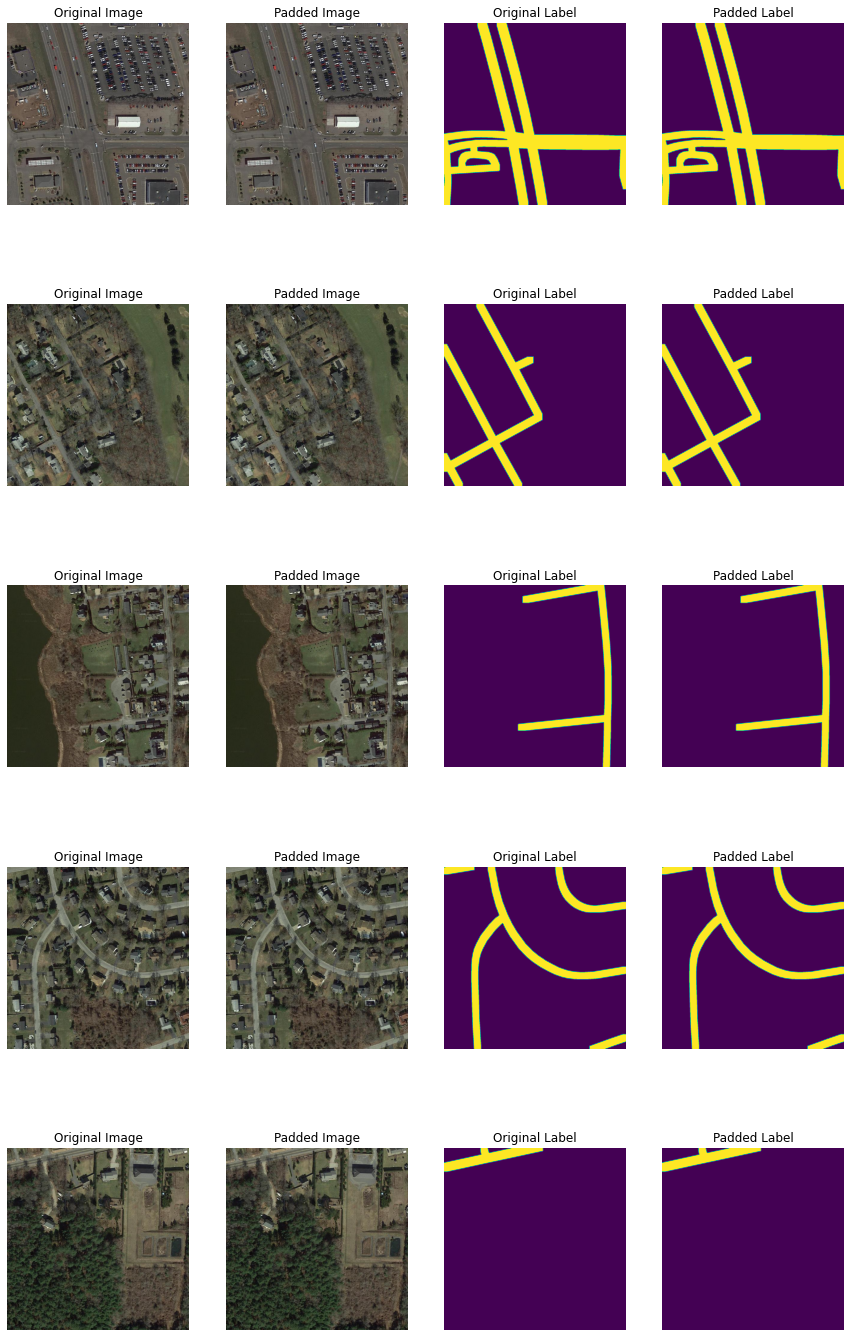

(2511, 608, 608, 3)
(2511, 608, 608, 1)


In [40]:
# Mirror padd all training images to get same size as test images
training_image_padded_list = []
training_label_padded_list = []
for i in range(n):
    training_image = training_image_list[i]
    training_label = training_label_list[i]
    height, width, _ = training_image.shape
    pad_y = int((IMG_HEIGHT - height) / 2)
    pad_x = int((IMG_WIDTH - height) / 2)
    training_image_padded_list.append(cv2.copyMakeBorder(training_image,pad_y,pad_y,pad_x,pad_x,cv2.BORDER_REFLECT))
    training_label_padded_list.append(cv2.copyMakeBorder(training_label,pad_y,pad_y,pad_x,pad_x,cv2.BORDER_REFLECT))

# Plot random Sample of images
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 4, i)
  plt.imshow(training_image_list[index])
  plt.title("Original Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(training_image_padded_list[index])
  plt.title("Padded Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(training_label_list[index]))
  plt.title("Original Label")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(training_label_padded_list[index]))
  plt.title("Padded Label")
  plt.axis('off')

plt.show()

# Convert image lists to numpy arrays for further processing
training_image = np.array(training_image_padded_list)
training_label = np.expand_dims(np.array(training_label_padded_list), -1)
test_image = np.array(test_image_list)
print(training_image.shape)
print(training_label.shape)

# Delete unused variables, hopefully this frees up some RAM
del training_image_list
del training_label_list
del training_image_padded_list
del training_label_padded_list

In [41]:
# Make sure label masks only have values 1 or zero
#thresh_val = 0.5
#training_label = (training_label > thresh_val).astype(np.uint8)
#training_label = training_label/255
training_label = training_label.astype(np.float32)
#print(np.unique(training_label, return_counts=True, axis=None))
print(training_label.dtype)

# Get a validation set
training_image, validation_image, training_label, validation_label = train_test_split(
    training_image, training_label, test_size=0.1, random_state=rnd_seed)

# Rescale validation images/labels and test images because generator will do the same with training data
validation_image = validation_image/255.0
validation_label = validation_label/255.0
validation_image = validation_image.astype(np.float32)
validation_label = validation_label.astype(np.float32)
print(validation_image.dtype)
test_image = test_image/255.0
test_image = test_image.astype(np.float32)
print(test_image.dtype)

float32
float32
float32


## Augment Training Data

We use the Keras Data Generator to augment our training data online while training. This is necessary because of memory consumption.

In [42]:
# We create an instance for the training images, training labels and test images
data_gen_args = dict(rescale=1.0/255.0,
                     #rotation_range=360,
                     #width_shift_range=0.05,
                     #height_shift_range=0.05,
                     #zoom_range=0.05,
                     #shear_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow(
    training_image,
    batch_size=BATCH_SIZE,
    #save_to_dir="training_images_augmented/images/",
    #save_prefix="",
    #save_format="png",
    seed=seed)
mask_generator = mask_datagen.flow(
    training_label,
    batch_size=BATCH_SIZE,
    #save_to_dir="training_images_augmented/groundtruth/",
    #save_prefix="",
    #save_format="png",
    seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss :
    - Dice Coef Loss (https://arxiv.org/pdf/1606.04797v1.pdf)
    - Soft Dice Loss (Measure of interleaving of prediction image and label image)
    - Jaccard Distance

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [43]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def soft_dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-soft_dice_coef(y_true, y_pred)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_coef(y_true, y_pred, smooth = 1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def combined_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

## Model: Fully CNN built in Keras

In [9]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 608, 608, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Callbacks for Observations

In [10]:
#tbc=TensorBoardColab()
model_path = "./Models/{}_model.h5".format(MODEL_NAME)
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/{}_log.csv".format(MODEL_NAME), separator=',', append=False)
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

/home/rmenta/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Model Training

In [11]:
opt = keras.optimizers.adam(LEARNING_RATE)
#opt = keras.optimizers.Nadam(lr=LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=dice_coef_loss,
      metrics=[iou_coef])

In [12]:
history = model.fit_generator(train_generator,
                              validation_data =(validation_image, validation_label),
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks = [checkpointer, csv_logger, lr_reducer, early_stopper])

Epoch 1/100
500/500 [==============================] - 399s 798ms/step - loss: 0.0832 - iou_coef: 0.2295 - val_loss: 0.0324 - val_iou_coef: 0.3107

Epoch 00001: val_loss improved from inf to 0.03244, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 2/100
500/500 [==============================] - 388s 775ms/step - loss: 0.0396 - iou_coef: 0.3104 - val_loss: 0.0242 - val_iou_coef: 0.3647

Epoch 00002: val_loss improved from 0.03244 to 0.02418, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 3/100
500/500 [==============================] - 388s 775ms/step - loss: 0.0288 - iou_coef: 0.3590 - val_loss: 0.0233 - val_iou_coef: 0.3651

Epoch 00003: val_loss improved from 0.02418 to 0.02335, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 4/100
500/500 [==============================] - 388s 776ms/step - loss: 0.0241 - iou_coef: 0.3856 - val_loss: 0.0199 - val_iou_coe

Epoch 32/100
500/500 [==============================] - 416s 831ms/step - loss: 0.0135 - iou_coef: 0.5560 - val_loss: 0.0131 - val_iou_coef: 0.5442

Epoch 00032: val_loss did not improve from 0.01302
Epoch 33/100
500/500 [==============================] - 416s 832ms/step - loss: 0.0138 - iou_coef: 0.5540 - val_loss: 0.0130 - val_iou_coef: 0.5481

Epoch 00033: val_loss did not improve from 0.01302

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 34/100
500/500 [==============================] - 416s 832ms/step - loss: 0.0135 - iou_coef: 0.5512 - val_loss: 0.0130 - val_iou_coef: 0.5474

Epoch 00034: val_loss improved from 0.01302 to 0.01302, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 35/100
500/500 [==============================] - 416s 833ms/step - loss: 0.0137 - iou_coef: 0.5544 - val_loss: 0.0131 - val_iou_coef: 0.5463

Epoch 00035: val_loss did not improve from 0.01302
Epoch 36/100
500/500 [=======

KeyboardInterrupt: 

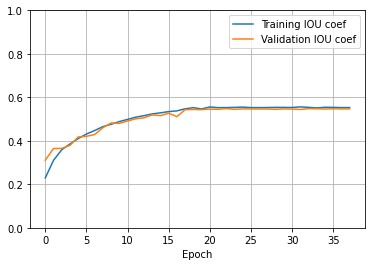

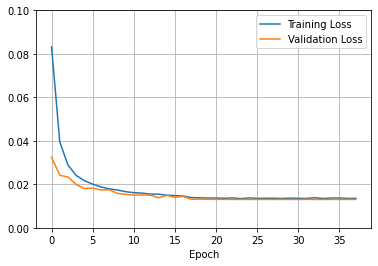

In [18]:
# Show a training report
training_info = pd.read_csv('./Logs/{}_log.csv'.format(MODEL_NAME), header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,0.1)
plt.grid(True)

plt.show()

## Model Evaluation

In [44]:
# Kaggle scores on validation images (mean score per image and overall mean score)
model = load_model("./Models/{}_model.h5".format(MODEL_NAME), custom_objects={'dice_coef_loss': dice_coef_loss, 'iou_coef': iou_coef})
y_pred = model.predict(validation_image, batch_size=4, verbose=1)
scores = util.validate_kaggle_score(validation_label, y_pred)
print(scores)
print(sum(scores)/len(scores))

252/252 [==============================] - 264s 1s/step

In [45]:
model = load_model("./Models/{}_model.h5".format(MODEL_NAME), custom_objects={'dice_coef_loss': dice_coef_loss, 'iou_coef': iou_coef})
#model.evaluate(test_images, test_label)
predictions = model.predict(test_image, batch_size=4, verbose=1) # shape: (752, 608, 608, 1)

752/752 [==============================] - 761s 1s/step

In [30]:
# since test_images contains 8 Images per prediction test_image -> average over these 8 images
count = 0
dif_rot = len(ROTATIONS)
final_im = test_image[0]
h,w = final_im.shape
temp_im =np.zeros((h,w,1),np.float)
for ti in predictions:
    if count % dif_rot == 0 and count != 0:
        # Round values in array and cast as 8-bit integer
        temp_im = np.array(np.round(temp_im),dtype=np.uint8)
        out = Image.fromarray(temp_im, mode='RGB')
        out.save('test_images/averaged/pic' + str(count/8) + '.png')
        # reset, new pic
        final_im = ti
        temp_im =np.zeros((h,w,3),np.float)
    # reverse rotation
    tim = Image.fromarray(ti, 'RGB')
    tim = tim.rotate(360-ROTATIONS[count % 8])
    # build average
    temp_im = temp_im + (ti/8)

(608, 608, 3)


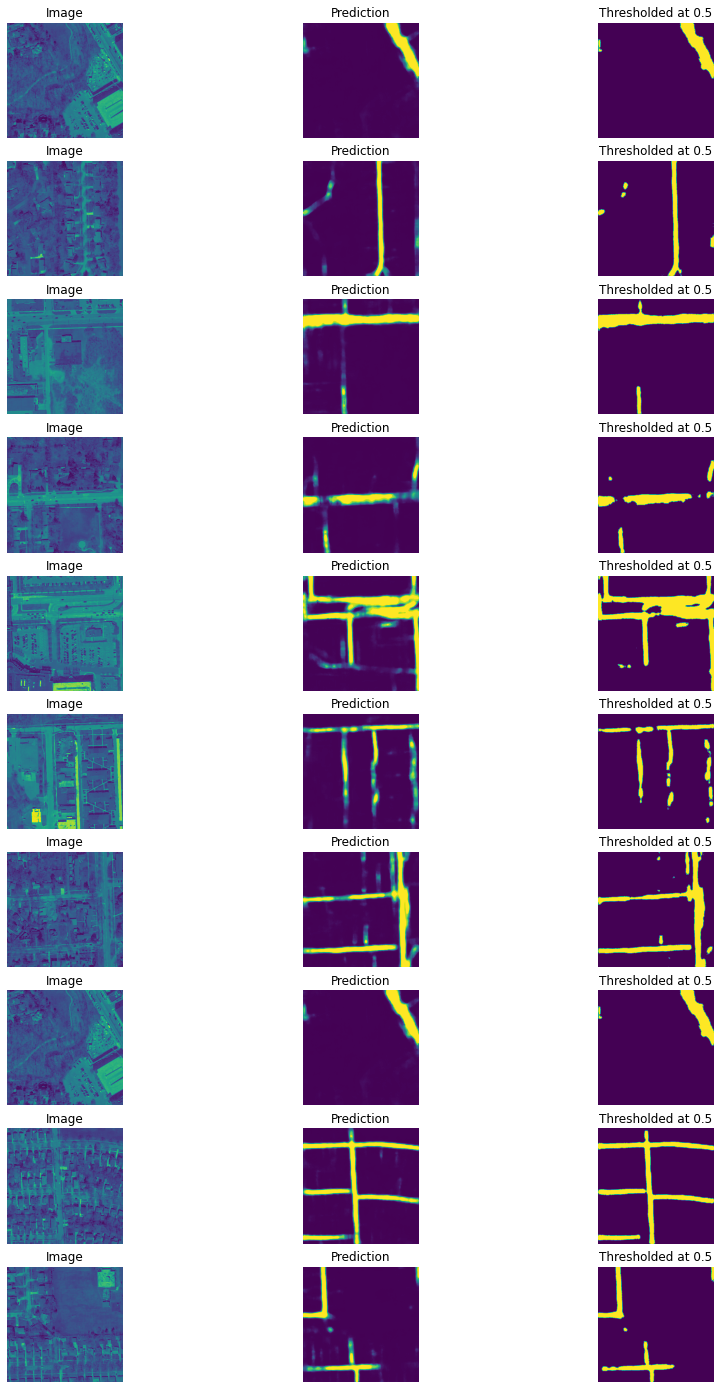

In [30]:
thresh_val = 0.5
predicton_threshold = (predictions > thresh_val).astype(np.uint8)


index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File
Multiply image by 255 and convert to unit8 before storing s.t. it gets read out correctly by mask_to_submission!

In [ ]:
predictions = np.squeeze(predictions*255)
predictions = predictions.astype(np.uint8)
result_dir = './Results/Prediction_Images/{}/'.format(MODEL_NAME)
os.makedirs(result_dir, exist_ok=True)

#print(predictions.shape)
#[print(predictions[i].shape) for i in range(n_test)]

[imageio.imwrite(result_dir + files_test[i], predictions[i],) for i in range(n_test)]
files_predictions = os.listdir(result_dir)
files_predictions = [result_dir + files_predictions[i] for i in range(n_test)]
masks_to_submission('./Results/Submissions/{}.csv'.format(MODEL_NAME), *files_predictions)
print('Submission ready')

./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_211.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_49.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_10.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_136.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_92.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_177.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_76.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_64.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_23.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_80.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_51.